# Seasonal Autoregressive Integrated Moving Average with Exogenous Regressors
### Model for time series forecasting with data containing trends and/or seasonality _and_ exogenous variables

In [106]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from statsmodels.tsa.statespace.sarimax import SARIMAX

Reading in CDC data and exogenous variables

In [107]:
df_hospital = pd.read_csv('../data/hospital_visits.csv')
df_hospital['Week'] = df_hospital.Week.map(str) + "-" + df_hospital.Year.map(str)
df_hospital = df_hospital[['Week', 'Total ILI']]
df_hospital.columns = ['Week', 'ILI']
df_hospital = df_hospital[28:256]
df_hospital = df_hospital.reset_index(drop=True)

df_twitter = pd.read_csv('../data/twitter-flu-data.csv', header=None)
df_twitter.columns = ['Year', 'Week', '1', '2', '3', '4', '5', '6', '7']
df_twitter['Week'] = df_twitter.Week.map(str) + "-" + df_twitter.Year.map(str)
df_twitter['Tweets'] = df_twitter[['1', '2', '3', '4', '5', '6', '7']].sum(axis=1)
df_twitter = df_twitter[['Week', 'Tweets']][27:-1]
df_twitter = df_twitter.reset_index(drop=True)

df_us = pd.read_csv('../data/USA_flu_virus_counts.csv')
df_us['Week'] = df_us.Week.map(str) + "-" + df_us.Year.map(str)
df_us = df_us[['Week', 'ALL_INF']]
df_us = df_us[786+27:1042]
df_us = df_us.drop(851)
df_us = df_us.reset_index(drop=True)

df_aus = pd.read_csv('../data/AUS_flu_virus_counts.csv')
df_aus['Week'] = df_aus.Week.map(str) + "-" + df_aus.Year.map(str)
df_aus = df_aus[['Week', 'ALL_INF']]
df_aus = df_aus[912:1168-27]
df_aus = df_aus.drop(977)
df_aus = df_aus.reset_index(drop=True)

df_google = pd.read_csv('../data/google_trends/flu_related_trends.csv')
df_google['Week'] = df_google.Week.map(str) + "-" + df_google.Year.map(str)
df_google = df_google[['Week', 'flu season', 'flu shot', 'flu symptoms', 'flu', 'flu vaccine', 'flu vs cold', 'cold flu', 'flu virus', 'stomach flu']]
df_google = df_google[17:246]
df_google = df_google.drop(159)
df_google = df_google.reset_index(drop=True)

In [108]:
list_hospital = list(df_hospital['ILI'])
list_tweets = list(df_twitter['Tweets'])
list_us = list(df_us['ALL_INF'])
list_aus = list(df_aus['ALL_INF'])
list_google = df_google[['flu season', 'flu shot', 'flu symptoms', 'flu', 'flu vaccine', 'flu vs cold', 'cold flu', 'flu virus', 'stomach flu']].values.tolist()

In [109]:
list_hospital_real = list_hospital[:-52]
list_tweets_real = list_tweets[:-52]
list_us_real = list_us[:-52]
list_aus_real = list_aus[:-52]
list_google_real = list_google[:-52]

list_hospital_pred = list_hospital[-52:]
list_tweets_pred = list_tweets[-52:]
list_us_pred = list_us[-52:]
list_aus_pred = list_aus[-52:]
list_google_pred = list_google[-52:]

In [110]:
features_transposed = [list_tweets_real, list_aus_real]
pred_transposed = [list_tweets_pred, list_aus_pred]

features = list(map(list, zip(*features_transposed)))
pred = list(map(list, zip(*pred_transposed)))

for feature_index in range(len(features)):
    features[feature_index].extend(list_google_real[feature_index])

for pred_index in range(len(pred)):
    pred[pred_index].extend(list_google_pred[pred_index])

google_transposed = list(map(list, zip(*list_google)))
to_plot_transposed = [list_tweets, list_aus]
to_plot_transposed.extend(google_transposed)

#### Defining the SARIMAX model - forecasting the last 52 weeks
Optimal order and seasonal_order (found via hyperparameter tuning in sarimax-script.py)

In [125]:
model = SARIMAX(endog=list_hospital_real, exog=features, order=(0, 1, 0), seasonal_order=(2, 1, 0, 52), enforce_stationarity=False, enforce_invertibility=False, trend='c')
model_fit = model.fit()

C:\Users\steph\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [126]:
future = 52
predictions = model_fit.predict(len(list_hospital_real), len(list_hospital_real) + future - 1, exog=pred)
future_weeks = list(range(len(list_hospital_real), len(list_hospital_real) + future))

In [127]:
predictions_df = pd.DataFrame([future_weeks, predictions]).transpose()
predictions_df.columns = ['Week', 'Total ILI']
predictions_df = predictions_df.set_index('Week')

Text(0.5, 1.0, 'Total ILI: 2014 - 2019 + predictions')

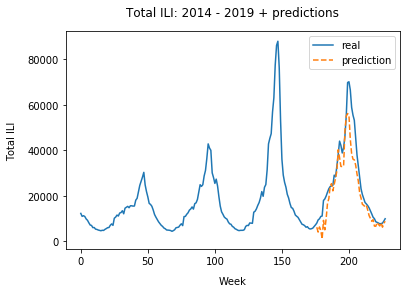

In [128]:
plt.plot(df_hospital['ILI'], label='real')
plt.plot(predictions_df, '--', label='prediction')
plt.legend()
plt.xlabel("Week", labelpad=10)
plt.ylabel("Total ILI", labelpad=10)
plt.title("Total ILI: 2014 - 2019 + predictions", pad=15)

In [121]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  176
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 52)   Log Likelihood                -629.925
Date:                            Tue, 10 Dec 2019   AIC                           1289.851
Time:                                    20:21:31   BIC                           1323.578
Sample:                                         0   HQIC                          1303.248
                                            - 176                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -21.8110    420.961     -0.052      0.959    -846.879     803.257
x1            -9.1339      5.066     -1.803      0.071     -19.062       0.795
x2             9.2090      7.126      1.292      0.196      -4.757      23.175
x3           -94.6458    162.680     -0.582      0.561    -413.493     224.201
x4          -454.8144    227.180     -2.002      0.045    -900.079      -9.549
x5           592.5350    156.113      3.796      0.000     286.560     898.510
x6           120.6022    106.636      1.131      0.258     -88.401     329.606
x7          -166.1451    100.558     -1.652      0.098    -363.236      30.945
x8            -7.7099    120.970     -0.064      0.949    -244.807     229.388
x9           157.4951    190.005      0.829      0.407    -214.908     529.898
x10          244.2871    120.820      2.022      0.043       7.484     481.090
x11          -90.9204     90.275     -1.007      0.314    -267.855      86.015
ar.L1          0.1736      0.248      0.699      0.484      -0.313       0.660
ar.S.L52       0.2601      0.199      1.309      0.191      -0.129       0.650
sigma2      4.067e+06   1.04e+06      3.911      0.000    2.03e+06     6.1e+06
===================================================================================
Ljung-Box (Q):                       33.50   Jarque-Bera (JB):               309.51
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               2.87   Skew:                            -2.31
Prob(H) (two-sided):                  0.01   Kurtosis:                        12.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 1.0, 'Total ILI + Features: 2014 - 2019')

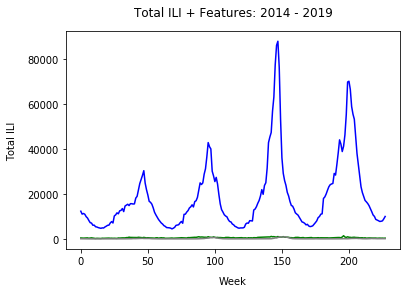

In [116]:
plt.plot(list_hospital, c='blue')
plt.plot(list_tweets, c='green')
plt.plot(list_aus, c='gray')
plt.xlabel("Week", labelpad=10)
plt.ylabel("Total ILI", labelpad=10)
plt.title("Total ILI + Features: 2014 - 2019", pad=15)